In [1]:
### Importing necessary libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
### Import reviews from all reviews file
df = pd.read_csv("All_reviews.csv")
df.shape

(1206, 4)

In [3]:
### Because we have nan values we are removing form our column
reviews = df.Reviews.dropna()
reviews

0                                                                                                                                       No autoduplex function.
1                                                                                                                                           GOOD PRODUCT SO FAR
2                                                                                                                                      scan colity are very bad
3                                                                                                                             Easy to assemble and very durable
4       Very useful for office use and good functional product with wi fi most suitable for everyone in their business as well as in office at affordable price
                                                                                 ...                                                                           
1201                                    

In [4]:
doc = nlp("Aditi is currently working in college as intern.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

Aditi ... nsubj
is ... aux
currently ... advmod
working ... ROOT
in ... prep
college ... pobj
as ... prep
intern ... pobj
. ... punct


#### Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

In [5]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [6]:
get_entities("Fazle have 200 patents in elctronics.")

['Fazle', '200  elctronics']

In [7]:
entity_pairs = []

for i in tqdm(reviews):
    entity_pairs.append(get_entities(i))

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.74it/s]


In [8]:
entity_pairs[10:20]

[['replaced/', 'also customer care regards'],
 ['good printer mine', '20  usage'],
 ['also  Price', 'bit  specification'],
 ['print speed', ''],
 ['original  it', 'original  cartridge'],
 ['', ''],
 ['', ''],
 ['you', 'whatever'],
 ['Printer', 'properly wifi aur usb'],
 ['It', 'really installation guide']]

#### Extracting Relations

In [9]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [10]:
get_relation("Nakul completed project")

'completed'

In [11]:
relations = [get_relation(i) for i in tqdm(reviews)]

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:08<00:00, 137.88it/s]


In [12]:
#### Printing the relations
pd.Series(relations).value_counts()[:50]

is              100
product          84
Good             56
printer          31
is good          24
working          20
good             19
quality          18
have             15
was              12
Nice             12
buy              12
's               11
easy             10
print             9
Easy              9
Product           9
recommend         8
works             7
Worth             7
?                 7
Awesome           6
got               6
is best           6
Ok                6
has               6
nice              6
was good          5
is little         5
is great          5
purchase          5
am                5
use               5
Go for            4
is excellent      4
like              4
get               4
using             4
want              4
's good           4
Value for         4
difficult         4
Working           4
value for         4
printer in        4
one               4
work              4
Excellent         4
Printer           3
take              3


#### Build Knowledge Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

In [13]:
#### Let’s create a dataframe of entities and predicates:

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,,,function
1,,,FAR
2,scan colity,,are
3,,,Easy
4,,affordable office price,useful for
...,...,...,...
1195,,,Like
1196,Good Everything,,works
1197,It,,'s
1198,,Good wifi,printer for


In [14]:
kg_df.edge.value_counts()

is               100
product           84
Good              56
printer           31
is good           24
                ... 
believe            1
AMAZON             1
Quality of         1
connecting to      1
LIKED              1
Name: edge, Length: 540, dtype: int64

In [15]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

#### Let’s plot the network:

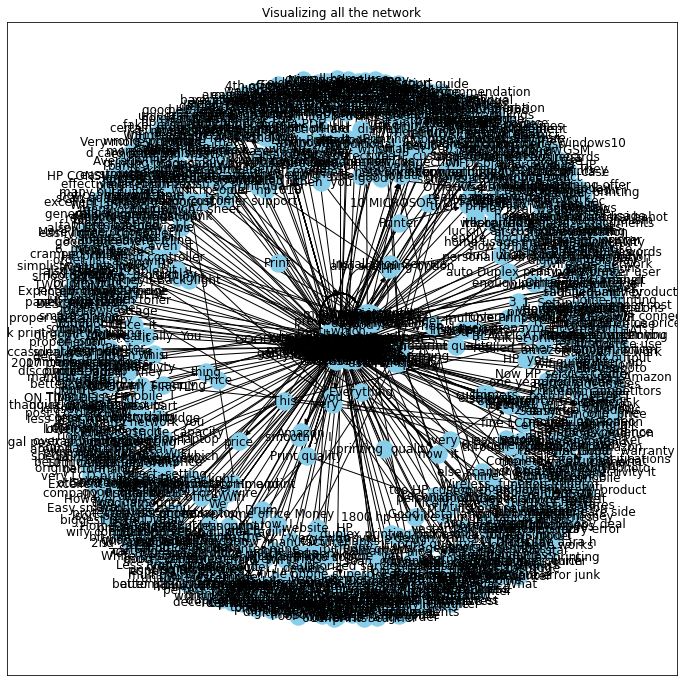

In [16]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw_networkx(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.title("Visualizing all the network")
plt.show()

Well, this is not exactly what we were hoping for 

#### Lets print only few relations 

#### Here we are using printer as our edge or relation

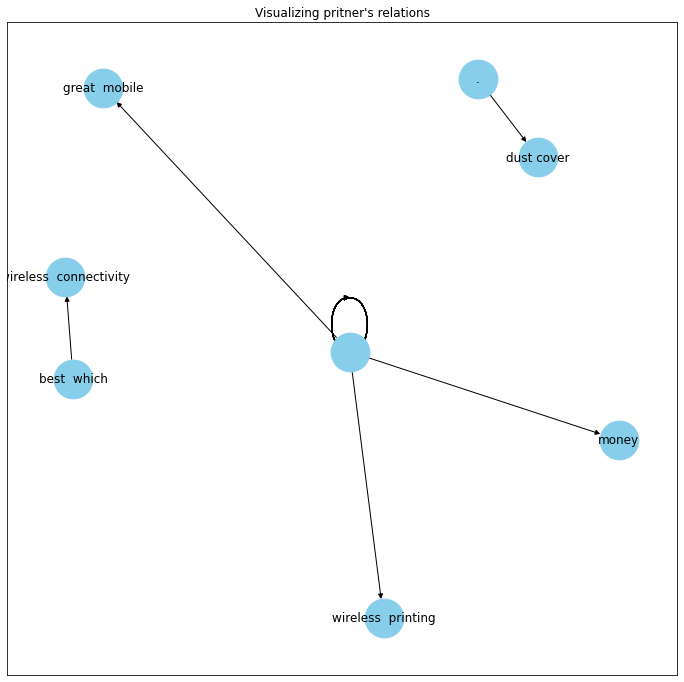

In [17]:
### For Pinter 
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="printer"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title("Visualizing pritner's relations")
plt.show()

#### Here we are visualizing product as relation

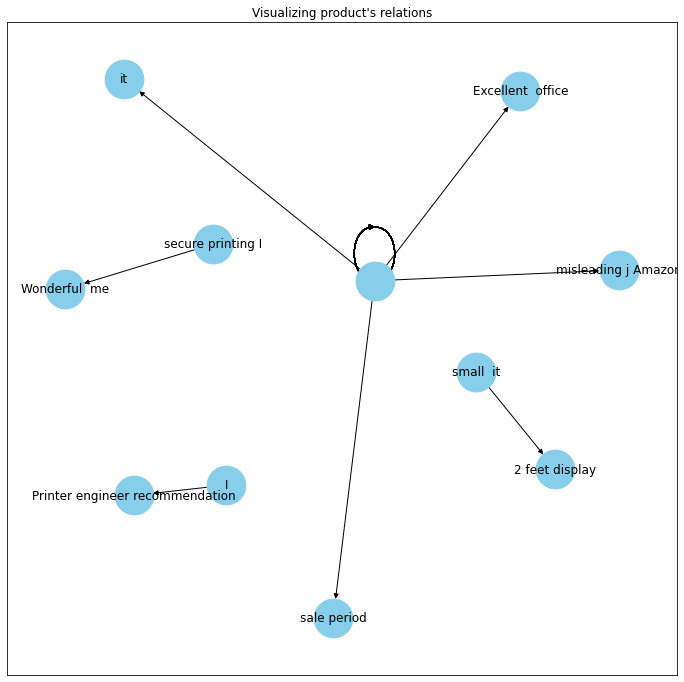

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="product"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title("Visualizing product's relations")
plt.show()

#### Because our most reviews are 5 star lets check is good and  Good as relationship

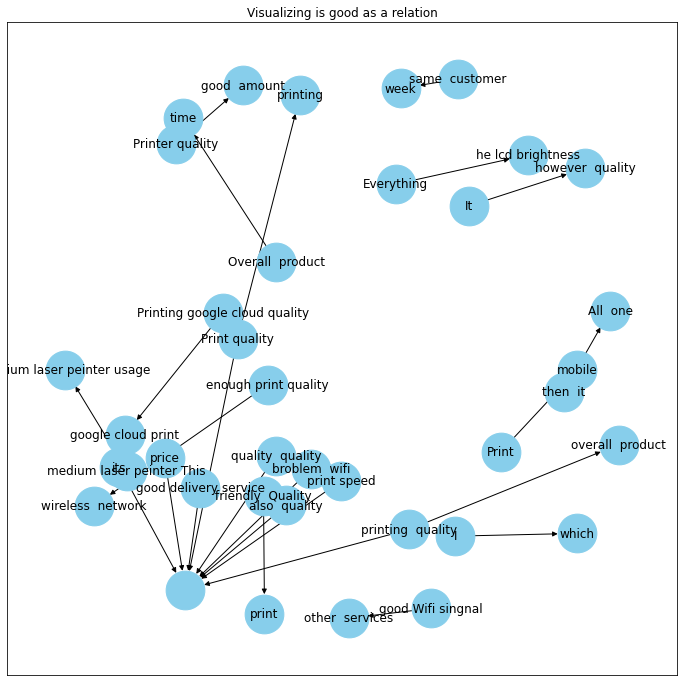

In [19]:
d = kg_df.loc[(kg_df['edge'] == 'is good')]
G=nx.from_pandas_edgelist(d, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title("Visualizing is good as a relation")
plt.show()

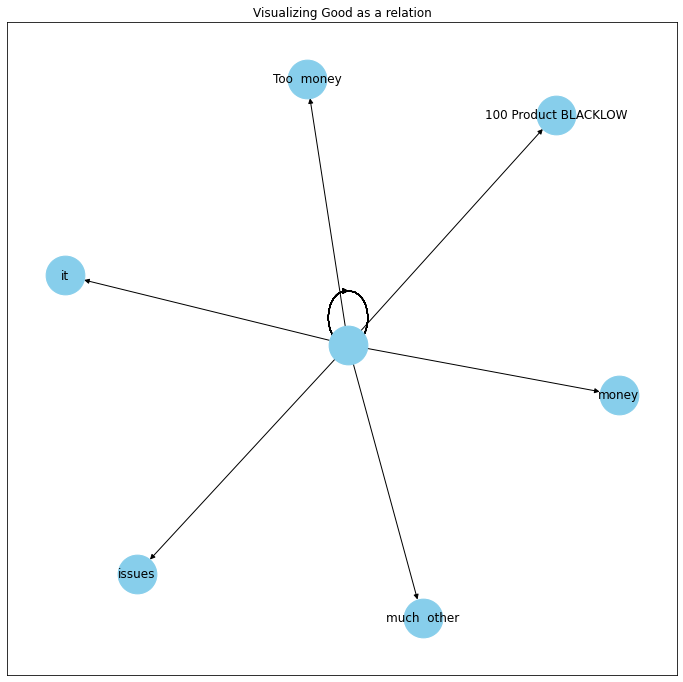

In [20]:
d = kg_df.loc[(kg_df['edge'] == 'Good')]
G=nx.from_pandas_edgelist(d, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title("Visualizing Good as a relation")
plt.show()